# OutlierTrimmer
The OutlierTrimmer() removes observations with outliers from the dataset.

It works only with numerical variables. A list of variables can be indicated.
Alternatively, the OutlierTrimmer() will select all numerical variables.

The OutlierTrimmer() first calculates the maximum and /or minimum values
beyond which a value will be considered an outlier, and thus removed.

Limits are determined using:

- a Gaussian approximation
- the inter-quantile range proximity rule
- percentiles.

### Example:

In [1]:
# importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from feature_engine.outliers import OutlierTrimmer

In [2]:
def load_titanic():
    # Load dataset from OpenML
    data = pd.read_csv('https://www.openml.org/data/get_csv/16826755/phpMYEkMl')
    
    # Replace '?' with NaN
    data = data.replace('?', np.nan)
    
    # Extract first letter of cabin
    data['cabin'] = data['cabin'].astype(str).str[0]
    
    # Convert 'pclass' to categorical
    data['pclass'] = data['pclass'].astype('O')
    
    # Ensure 'age' contains only numeric data by coercing errors to NaN
    data['age'] = pd.to_numeric(data['age'], errors='coerce')
    
    # Fill missing values in 'age' with the median age
    data['age'].fillna(data['age'].median(), inplace=True)
    
    # Ensure 'fare' contains only numeric data by coercing errors to NaN
    data['fare'] = pd.to_numeric(data['fare'], errors='coerce')
    
    # Fill missing values in 'fare' with the median fare
    data['fare'].fillna(data['fare'].median(), inplace=True)
    
    # Fill missing values in 'embarked' with 'C'
    data['embarked'].fillna('C', inplace=True)
    
    # Drop irrelevant columns
    data.drop(labels=['name', 'ticket'], axis=1, inplace=True)
    
    return data

# Load the data
data = load_titanic()

# Display the first few rows of the cleaned data
data.head()

C:\Users\devanshu.tayal\AppData\Local\Temp\ipykernel_10224\2003671112.py:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['age'].fillna(data['age'].median(), inplace=True)
C:\Users\devanshu.tayal\AppData\Local\Temp\ipykernel_10224\2003671112.py:24: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always b

,pclass,survived,sex,age,sibsp,parch,fare,cabin,embarked,boat,body,home.dest
0,1,1,female,29.0000,0,0,211.3375,B,S,2,NaN,"St Louis, MO"
1,1,1,male,0.9167,1,2,151.5500,C,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1,0,female,2.0000,1,2,151.5500,C,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,1,0,male,30.0000,1,2,151.5500,C,S,NaN,135,"Montreal, PQ / Chesterville, ON"
4,1,0,female,25.0000,1,2,151.5500,C,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"


In [3]:
# let's separate into training and testing set

X_train, X_test, y_train, y_test = train_test_split(data.drop('survived', axis=1),
                                                    data['survived'],
                                                    test_size=0.3,
                                                    random_state=0)

print("train data shape before removing outliers:", X_train.shape)
print("test data shape before removing outliers:", X_test.shape)

train data shape before removing outliers: (916, 11)
test data shape before removing outliers: (393, 11)


In [4]:
# let's find out the maximum Age and maximum Fare in the titanic

print("Max age:", data.age.max())
print("Max fare:", data.fare.max())

print("Min age:", data.age.min())
print("Min fare:", data.fare.min())

Max age: 80.0
Max fare: 512.3292
Min age: 0.1667
Min fare: 0.0


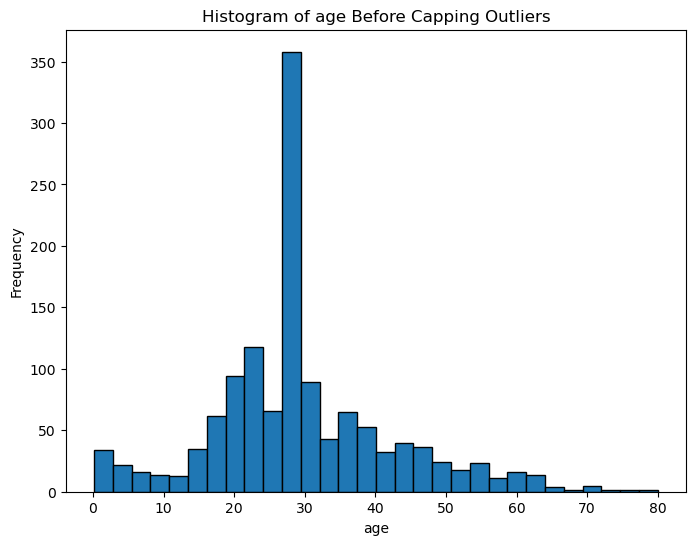

In [5]:
# Assuming 'data' is a DataFrame and has a 'fare' column
plt.figure(figsize=(8, 6))
plt.hist(data['age'], bins=30, edgecolor='black')
plt.title('Histogram of age Before Capping Outliers')
plt.xlabel('age')
plt.ylabel('Frequency')
plt.show()

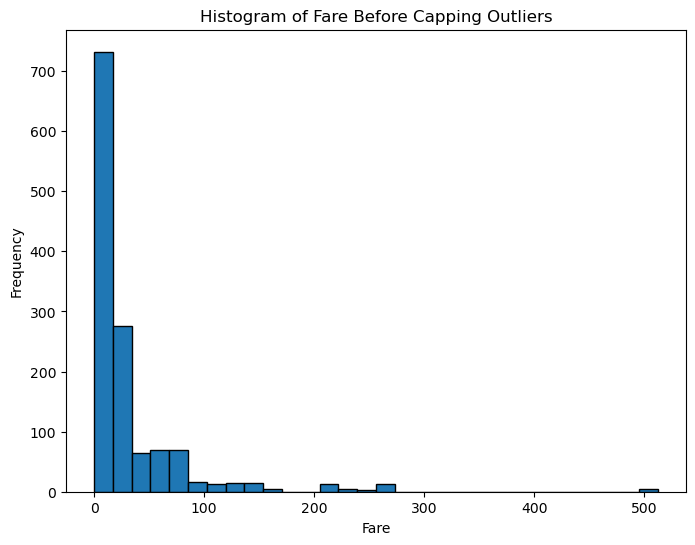

In [6]:
# Assuming 'data' is a DataFrame and has a 'fare' column
plt.figure(figsize=(8, 6))
plt.hist(data['fare'], bins=30, edgecolor='black')
plt.title('Histogram of Fare Before Capping Outliers')
plt.xlabel('Fare')
plt.ylabel('Frequency')
plt.show()

### Outlier trimming using Gaussian limits:
The transformer will find the maximum and / or minimum values to
    trim the variables using the Gaussian approximation.


- right tail: mean + 3* std
- left tail: mean - 3* std

In [7]:
'''Parameters
----------

capping_method : str, default=gaussian
    Desired capping method. Can take 'gaussian', 'iqr' or 'quantiles'.
    
tail : str, default=right
    Whether to cap outliers on the right, left or both tails of the distribution.
    Can take 'left', 'right' or 'both'.

fold: int or float, default=3
    How far out to to place the capping values. The number that will multiply
    the std or IQR to calculate the capping values.

variables : list, default=None

missing_values: string, default='raise'
    Indicates if missing values should be ignored or raised.'''

# removing outliers based on right tail of age and fare columns using gaussian capping method
trimmer = OutlierTrimmer(
    capping_method='gaussian', tail='right', fold=3, variables=['age', 'fare'])

# fitting trimmer object to training data
trimmer.fit(X_train)

OutlierTrimmer(fold=3, variables=['age', 'fare'])

In [8]:
# here we can find the maximum caps allowed
trimmer.right_tail_caps_

{'age': 67.46990824959815, 'fare': 174.7039533684667}

In [9]:
# this dictionary is empty, because we selected only right tail
trimmer.left_tail_caps_

{}

In [10]:
# transforming the training and testing data
train_t = trimmer.transform(X_train)
test_t = trimmer.transform(X_test)

# let's check the new maximum Age and maximum Fare in the titanic
print("Max age:", train_t.age.max())
print("Max fare:", train_t.fare.max())

Max age: 66.0
Max fare: 164.8667


In [11]:
print("train data shape after removing outliers:", train_t.shape)
print(f"{X_train.shape[0] - train_t.shape[0]} observations are removed\n")

print("test data shape after removing outliers:", test_t.shape)
print(f"{X_test.shape[0] - test_t.shape[0]} observations are removed")

train data shape after removing outliers: (887, 11)
29 observations are removed

test data shape after removing outliers: (376, 11)
17 observations are removed


### Gaussian approximation trimming, both tails

In [12]:
# Trimming the outliers at both tails using gaussian  method
trimmer = OutlierTrimmer(
    capping_method='gaussian', tail='both', fold=2, variables=['fare', 'age'])
trimmer.fit(X_train)

OutlierTrimmer(fold=2, tail='both', variables=['fare', 'age'])

In [13]:
print("Minimum caps :", trimmer.left_tail_caps_)

print("Maximum caps :", trimmer.right_tail_caps_)

Minimum caps : {'fare': -62.2492183664596, 'age': 4.69527950754593}
Maximum caps : {'fare': 127.31331902148143, 'age': 54.914982501187694}


In [14]:
# transforming the training and testing data
train_t = trimmer.transform(X_train)
test_t = trimmer.transform(X_test)

print("train data shape after removing outliers:", train_t.shape)
print(f"{X_train.shape[0] - train_t.shape[0]} observations are removed\n")

print("test data shape after removing outliers:", test_t.shape)
print(f"{X_test.shape[0] - test_t.shape[0]} observations are removed")

train data shape after removing outliers: (803, 11)
113 observations are removed

test data shape after removing outliers: (334, 11)
59 observations are removed


### Inter Quartile Range, both tails
The transformer will find the boundaries using the IQR proximity rule.
**IQR limits:**

- right tail: 75th quantile + 3* IQR
- left tail:  25th quantile - 3* IQR

where IQR is the inter-quartile range: 75th quantile - 25th quantile.


In [15]:
# trimming at both tails using iqr capping method
trimmer = OutlierTrimmer(
    capping_method='iqr', tail='both', variables=['age', 'fare'])

trimmer.fit(X_train)

OutlierTrimmer(capping_method='iqr', tail='both', variables=['age', 'fare'])

In [16]:
print("Minimum caps :", trimmer.left_tail_caps_)

print("Maximum caps :", trimmer.right_tail_caps_)

Minimum caps : {'age': 5.0, 'fare': -27.172999999999995}
Maximum caps : {'age': 53.0, 'fare': 66.34379999999999}


In [17]:
# transforming the training and testing data
train_t = trimmer.transform(X_train)
test_t = trimmer.transform(X_test)

print("train data shape after removing outliers:", train_t.shape)
print(f"{X_train.shape[0] - train_t.shape[0]} observations are removed\n")

print("test data shape after removing outliers:", test_t.shape)
print(f"{X_test.shape[0] - test_t.shape[0]} observations are removed")

train data shape after removing outliers: (729, 11)
187 observations are removed

test data shape after removing outliers: (310, 11)
83 observations are removed


### percentiles or quantiles:
The limits are given by the percentiles.
- right tail: 98th percentile
- left tail:  2nd percentile

In [18]:
# trimming at both tails using quantiles capping method
trimmer = OutlierTrimmer(capping_method='quantiles',
                         tail='both', fold=0.02, variables=['age', 'fare'])

trimmer.fit(X_train)

OutlierTrimmer(capping_method='quantiles', fold=0.02, tail='both',
               variables=['age', 'fare'])

In [19]:
print("Minimum caps :", trimmer.left_tail_caps_)

print("Maximum caps :", trimmer.right_tail_caps_)

Minimum caps : {'age': 2.0, 'fare': 6.44125}
Maximum caps : {'age': 61.69999999999993, 'fare': 211.5}


In [20]:
# transforming the training and testing data
train_t = trimmer.transform(X_train)
test_t = trimmer.transform(X_test)

print("train data shape after removing outliers:", train_t.shape)
print(f"{X_train.shape[0] - train_t.shape[0]} observations are removed\n")

print("test data shape after removing outliers:", test_t.shape)
print(f"{X_test.shape[0] - test_t.shape[0]} observations are removed")

train data shape after removing outliers: (852, 11)
64 observations are removed

test data shape after removing outliers: (358, 11)
35 observations are removed


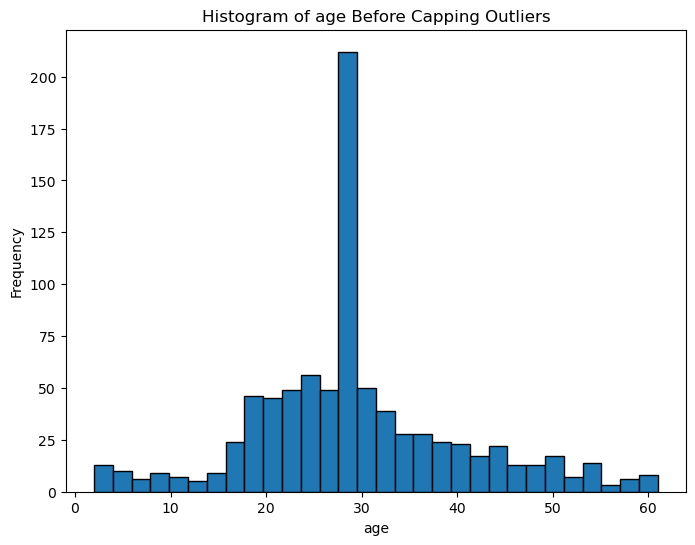

In [21]:
# Assuming 'data' is a DataFrame and has a 'fare' column
plt.figure(figsize=(8, 6))
plt.hist(train_t['age'], bins=30, edgecolor='black')
plt.title('Histogram of age Before Capping Outliers')
plt.xlabel('age')
plt.ylabel('Frequency')
plt.show()

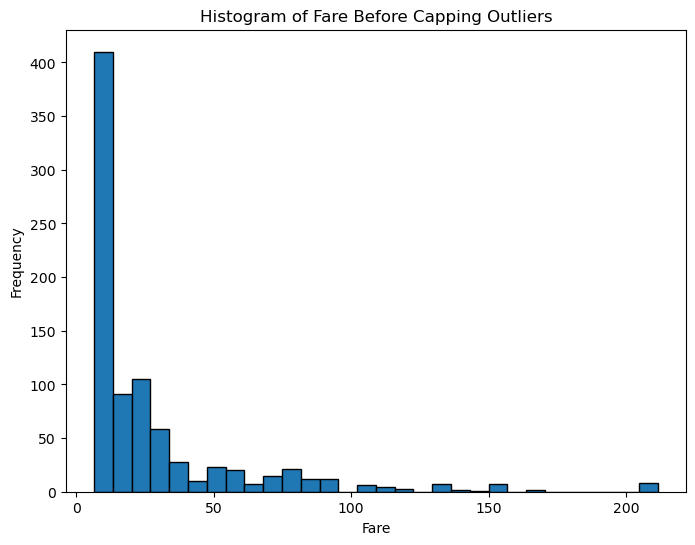

In [22]:
# Assuming 'data' is a DataFrame and has a 'fare' column
plt.figure(figsize=(8, 6))
plt.hist(train_t['fare'], bins=30, edgecolor='black')
plt.title('Histogram of Fare Before Capping Outliers')
plt.xlabel('Fare')
plt.ylabel('Frequency')
plt.show()